<a href="https://colab.research.google.com/github/dwarfy35/deep_learning2/blob/main/FontCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive
from torch.autograd import grad
from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset
from torch.autograd import grad
from collections import defaultdict

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
ngf = 32
nc = 1
ndf = 32

In [ ]:
class Generator3(nn.Module):
    def __init__(self, latent_dim):
        super(Generator3, self).__init__()

        self.init_size = 2  # Initial spatial size
        self.latent_dim = latent_dim

        # In the paper it is not specified z transforms into a 4x4x512 (for 64x64 data) so we will use a linear layer to do so.
        self.fc = nn.Linear(latent_dim, 512 * self.init_size * self.init_size)
        # No relu because we just had to reshape the latent vector to something that when flattened is 2 * 32^2, which 2x2x512 is


        # We make the transposed convolutional layers (fractionally strided convolutions)
        self.deconv_blocks = nn.Sequential(
            # Block 1: Input (2x2x512) -> Output (4x4x256)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # Block 2: Input (4x4x256)-> Output (8x8x128)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # Block 3: Input (8x8x128) -> Output (16x16x64)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # Final Block: Input (16x16x64) -> Output (32x32x1)
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        # Pass the latent vector through the fully connected layer
        out = self.fc(z)

        # Reshape to match the initial feature map dimensions. out.size(0) = batch size.
        out = out.view(out.size(0), 512, self.init_size, self.init_size)

        # We pass "out" through the transposed convolutional blocks
        img = self.deconv_blocks(out)

        return img

class Discriminator3(nn.Module):
    def __init__(self, nc=1, ndf=32, ngpu=1):
        """
        Args:
            nc: Number of channels in the input image (e.g., 1 for grayscale).
            ndf: Number of filters in the first convolutional layer.
            ngpu: Number of GPUs available for training.
        """
        super(Discriminator3, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input: (nc) x 32 x 32
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),  # 32x32 → 16x16
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 16x16 → 8x8
            #nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 8x8 → 4x4
            #nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),  # 4x4 → 1x1
            nn.Sigmoid()  # Output scalar probability
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
npz_file = '/content/gdrive/My Drive/character_font.npz'

class NPZDataset(Dataset):
    def __init__(self, npz_file, transform=None, filter_label=None, num_samples=None):
        # Load the data from the .npz file
        data = np.load(npz_file)
        self.images = data['images']
        self.labels = data['labels']
        self.transform = transform

        # Filter by label if specified
        if filter_label is not None:
            # Find indices of the desired label
            label_indices = np.where(self.labels == filter_label)[0]

            # If num_samples is specified, limit the number of samples
            if num_samples is not None:
                label_indices = label_indices[:num_samples]

            # Filter images and labels
            self.images = self.images[label_indices]
            self.labels = self.labels[label_indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image and label for the given index
        image = self.images[idx]
        label = self.labels[idx]

        # Reshape the image to add a channel dimension
        image = image[np.newaxis, ...]  # Add channel dimension at the beginning

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert to PyTorch tensor if necessary
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1, device=real_samples.device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [ ]:
def number_to_alphabet(num):
    if 0 <= num <= 25:
        return chr(num + 65)  # 65 is the ASCII code for 'A'
    else:
        raise ValueError("Number must be between 0 and 25 inclusive.")


In [ ]:
def displayGeneratedImage(class_index, generator, z_dim, num_classes, device='cuda'):
    """
    Generates and displays an image for a given class using the generator.

    Args:
        class_index (int): Index of the character class to generate (0 to num_classes - 1).
        generator (nn.Module): Pre-trained generator model.
        z_dim (int): Dimension of the style vector.
        num_classes (int): Number of character classes.
        device (str): Device for computation ('cuda' or 'cpu').
    """
    # Ensure the class index is valid
    if not (0 <= class_index < num_classes):
        raise ValueError(f"Invalid class_index: {class_index}. Must be in range [0, {num_classes - 1}].")

    # Create the one-hot vector for the class
    z_c = torch.zeros(1, num_classes, device=device)
    z_c[0, class_index] = 1  # Set the desired class

    # Create the random style vector
    z_s = torch.randn(1, z_dim, device=device)

    # Concatenate the style and class vectors
    z = torch.cat((z_s, z_c), dim=1)

    # Generate the image
    with torch.no_grad():
        generated_img = generator(z).cpu().numpy()[0, 0]  # Extract the first batch and first channel

    # Rescale the image from [-1, 1] to [0, 255]
    #generated_img = np.rot90(generated_img, k=-1)
    generated_img = np.uint8(np.interp(generated_img, (-1, 1), (0, 255)))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(generated_img, cmap='gray')
    plt.axis("off")
    plt.title(f"Generated Image for Class {number_to_alphabet(class_index)}")
    plt.show()


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

#dataset = NPZDataset(npz_file, transform=transform)

In [ ]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, device="cuda"):
    """
    Compute the gradient penalty for WGAN-GP.

    Args:
        discriminator: The discriminator model.
        real_samples: Batch of real images.
        fake_samples: Batch of fake images generated by the generator.
        device: The device to run the computations on.

    Returns:
        Gradient penalty (scalar).
    """
    # Interpolate between real and fake samples
    alpha = torch.randn(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Pass interpolated samples through the discriminator
    d_interpolates = discriminator(interpolates)  # Output shape: [batch_size, 1, 1, 1] or [batch_size, 1]

    # Ensure the output is flat
    d_interpolates = d_interpolates.view(-1)  # Flatten to [batch_size]

    # Create grad_outputs for the gradient computation
    fake = torch.ones(d_interpolates.size(), device=device)

    # Compute gradients of the discriminator's output w.r.t. interpolated inputs
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)  # Flatten gradients
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [ ]:
# Hyperparameters
z_dim = 100
num_classes = 26  # For uppercase alphabets
img_size = 32  # Assuming 32x32 images
batch_size = 1024
lr = 0.0002
lambda_gp = 10  # Gradient penalty weight
n_critic = 5  # Number of discriminator updates per generator update
epochs = 2500

fullData = NPZDataset(npz_file, transform)
train_data,test_data = train_test_split(fullData,test_size = 0.1)

<ipython-input-19-4f3e8d9164e4>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


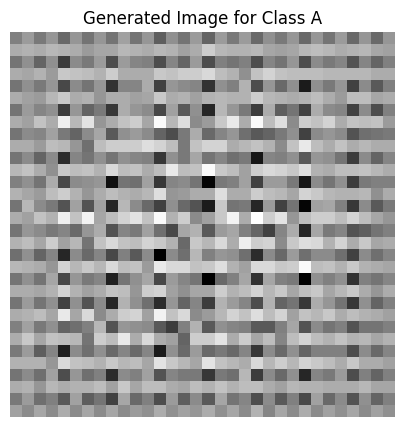

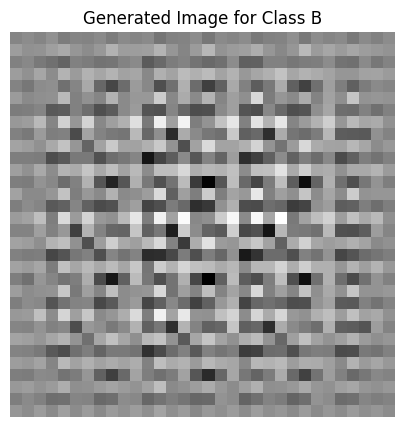

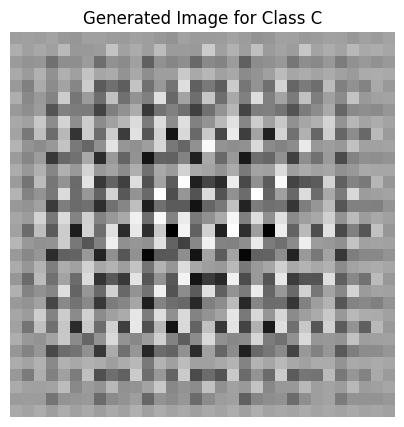

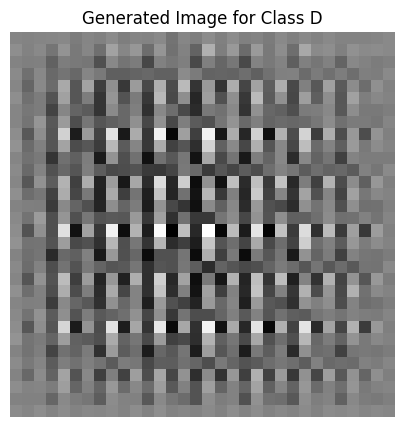

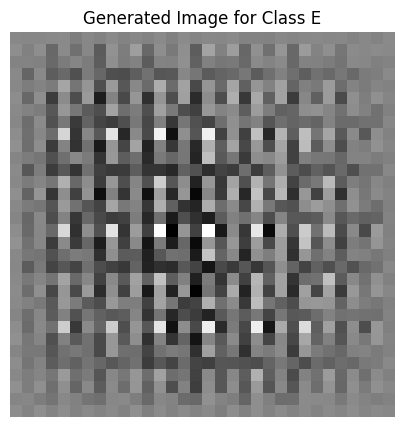

KeyboardInterrupt: 

In [27]:

grouped_data = defaultdict(list)
for img, label in train_data:
    grouped_data[label.item()].append((img, label))

# Convert grouped data into datasets
grouped_datasets = {label: [(img, lbl) for img, lbl in imgs] for label, imgs in grouped_data.items()}
grouped_dataloaders = {
    letter: DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for letter, dataset in grouped_datasets.items()
}

#dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models and optimizers
generator = Generator3(126).cuda()
discriminator = Discriminator3(nc=1, ndf=32, ngpu=1).cuda()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

# Training
for epoch in range(epochs):
  for letter in range(num_classes):  # Iterate over 26 letters (A-Z)
    dataloader = grouped_dataloaders[letter]
    for i, (real_imgs, labels) in enumerate(dataloader):
        # Fix real_imgs shape
        real_imgs = real_imgs.permute(0, 2, 3, 1).cuda()  # Convert to (batch_size, channels, height, width)
        labels = labels.cuda()
        batch_size = labels.shape[0]
        # Generate one-hot vectors for labels
        z_c = torch.zeros(batch_size, num_classes).cuda()
        z_c[torch.arange(batch_size), labels] = 1

        # Train Discriminator
        z_s = torch.randn(batch_size, z_dim).cuda()
        z = torch.cat((z_s, z_c), dim=1)  # Shape: (batch_size, z_dim + num_classes)
        fake_imgs = generator(z)
        real_validity = discriminator(real_imgs)
        fake_validity = discriminator(fake_imgs.detach())  # Detach to avoid affecting generator
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, fake_imgs)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator every n_critic steps
        if i % n_critic == 0:
            z_s = torch.randn(batch_size, z_dim).cuda()  # Regenerate z_s
            z = torch.cat((z_s, z_c), dim=1)  # Shape: (batch_size, z_dim + num_classes)
            fake_imgs = generator(z)  # Generate new fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            optimizer_G.zero_grad()
            g_loss.backward()  # No retain_graph needed
            optimizer_G.step()

    displayGeneratedImage(class_index=letter, generator=generator, z_dim=z_dim, num_classes=num_classes, device='cuda')
  print(f"Epoch [{epoch+1}/{epochs}], D_loss: {d_loss.item()}, G_loss: {g_loss.item()}")